In this notebook we test the implementation of the train/test set.

In [1]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import Siren
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Clustering, Threshold
from deepymod_torch.training import train_auto_split, train_auto_split_scaled
from deepymod_torch.training.sparsity_scheduler import Periodic, TrainTest

from phimal_utilities.data import Dataset
from phimal_utilities.data.kdv import DoubleSoliton

from phimal_utilities.analysis import load_tensorboard, Results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2
%load_ext tensorboard

if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Buildig data sets

In [73]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-5, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=[5.0, 2.0], x0=[-3.0, -1.0])


X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=5000, noise=0.0, normalize=True, random=True)

X, y = X_train.to(device), y_train.to(device)
X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=True, random=False)
X_full, y_full = X_full.to(device), y_full.to(device)

In [74]:
min_MSE = (0.1 * np.std(y_full.cpu().numpy()))**2
print(min_MSE)

0.004087235284578697


In [75]:
X_train.shape

torch.Size([5000, 2])

# Running

In [ ]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=1000, periodicity=100) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

train_test(model, X_train, y_train, X_test, y_test, optimizer, sparsity_scheduler, log_dir='data/train_test_sparsity_0.5/', write_iterations=25, max_iterations=5000, delta=0.0) # Running

# Analyzing

In [19]:
df = Results('data/train_test_sparsity/')

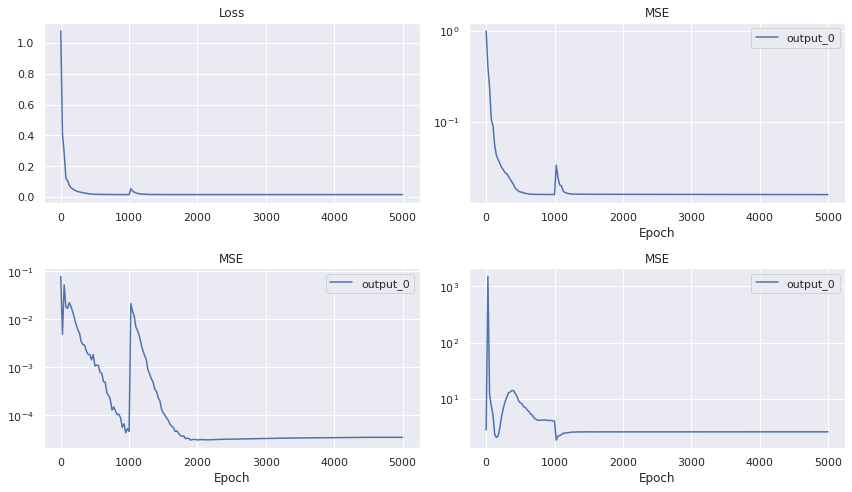

In [20]:
df.plot_losses()

Let's look at things in-depth:

Text(0.5, 1.0, 'Total loss')

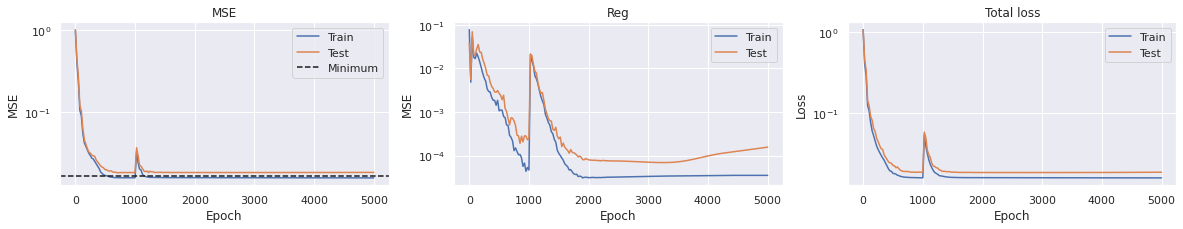

In [21]:
plt.figure(figsize=(20, 3))
plt.subplot(131)

plt.semilogy(df.df[df.keys['mse']], label='Train')
plt.semilogy(df.df['remaining_MSE_test'], label='Test')
plt.axhline(min_MSE, color='k', linestyle='--', label='Minimum')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE')

plt.subplot(132)
plt.semilogy(df.df[df.keys['reg']], label='Train')
plt.semilogy(df.df['remaining_Reg_test'], label='Test')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Reg')


plt.subplot(133)
plt.semilogy(df.df[df.keys['loss']], label='Train')
plt.semilogy(df.df['remaining_loss_test'], label='Test')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total loss')

Minima is at each respective point for the test set:

In [8]:
print(df.df.index[df.df['remaining_loss_test'].argmin()], df.df.index[df.df['remaining_MSE_test'].argmin()], df.df.index[df.df['remaining_Reg_test'].argmin()]) 

1275 1000 1275


And for the training set:

In [9]:
print(df.df[df.keys['loss']].idxmin(), df.df[df.keys['mse']].idxmin().item(), df.df[df.keys['reg']].idxmin().item()) 

4975 5000 1425


Can we superimpose this with the coefficients? Let's use unscaled cause thats easier:

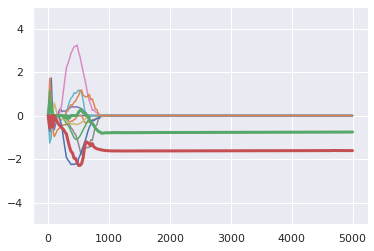

In [10]:
plt.plot(df.df[df.keys['estimator_coeffs']])
plt.plot(df.df[df.keys['estimator_coeffs'][3]], lw=3)
plt.plot(df.df[df.keys['estimator_coeffs'][5]], lw=3)
plt.ylim([-5, 5])
plt.show()

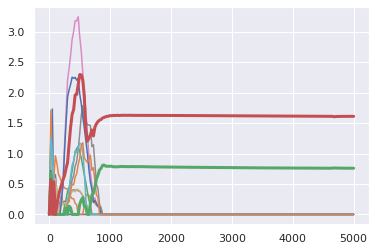

In [11]:
plt.plot(np.abs(df.df[df.keys['estimator_coeffs']]))
plt.plot(np.abs(df.df[df.keys['estimator_coeffs'][3]]), lw=3)
plt.plot(np.abs(df.df[df.keys['estimator_coeffs'][5]]), lw=3)
#plt.ylim([-5, 5])
plt.show()

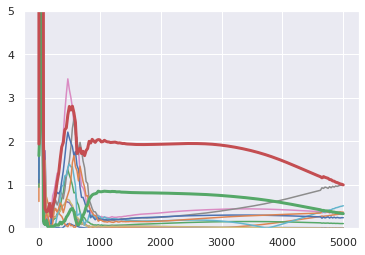

In [16]:
plt.plot(np.abs(df.df[df.keys['coeffs']]))
plt.plot(np.abs(df.df[df.keys['coeffs'][3]]), lw=3)
plt.plot(np.abs(df.df[df.keys['coeffs'][5]]), lw=3)
plt.ylim([0, 5])
plt.show()

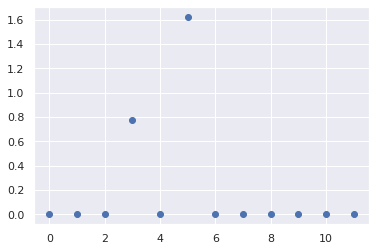

In [13]:
plt.plot(np.arange(12), np.abs(df.df[df.keys['estimator_coeffs']].loc[2000]), 'o')
#plt.ylim([-5, 5])
plt.show()

In [17]:
predicted = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)
true = y_full.cpu().detach().numpy().reshape(x_grid.shape)

NameError: name 'model' is not defined

In [18]:
frame = 10
plt.plot(x, predicted[:, frame])
plt.plot(x, true[:, frame])

NameError: name 'predicted' is not defined

So there is a minimum. Let's try and write a training which runs until that minimum, than applies sparsity.

# Writing training loop

In [33]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

# Running model
sparsity_scheduler = TrainTest(patience=200)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer
_
train_auto_split(model, X, y, optimizer,sparsity_scheduler, split=0.8, log_dir='data/testing_5000_0.3_non_scaled_2/', write_iterations=25, max_iterations=5000, delta=0.01) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1375     27.50%             175s   3.56e-02   3.56e-02   3.24e-05   4.30e+00 [tensor([False, False, False,  True, False,  True, False,  True, False, False,
        False,  True], device='cuda:0')]
       1950     39.00%             145s   3.57e-02   3.56e-02   6.22e-05   3.42e+00 [tensor([False, False, False,  True, False,  True, False, False, False, False,
        False, False], device='cuda:0')]
       2425     48.50%             121s   3.57e-02   3.57e-02   6.46e-05   2.67e+00 Algorithm converged. Stopping training.


In [57]:
X.shape

torch.Size([5000, 2])

In [34]:
df = Results('data/testing_5000_0.3_non_scaled_2/')

Text(0.5, 1.0, 'Total loss')

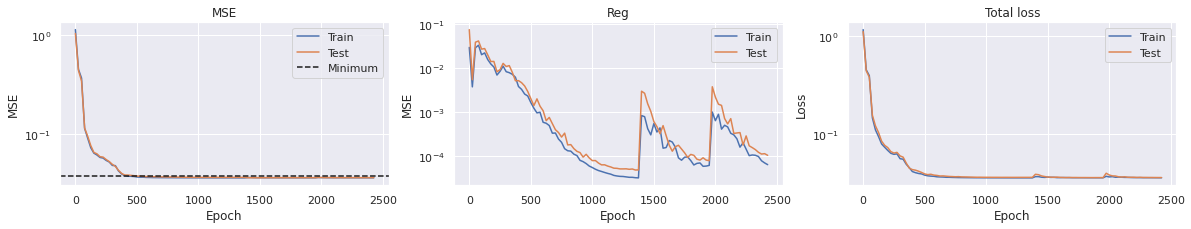

In [37]:
plt.figure(figsize=(20, 3))
plt.subplot(131)

plt.semilogy(df.df[df.keys['mse']], label='Train')
plt.semilogy(df.df['remaining_MSE_test'], label='Test')
plt.axhline(min_MSE, color='k', linestyle='--', label='Minimum')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE')

plt.subplot(132)
plt.semilogy(df.df[df.keys['reg']], label='Train')
plt.semilogy(df.df['remaining_Reg_test'], label='Test')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Reg')


plt.subplot(133)
plt.semilogy(df.df[df.keys['loss']], label='Train')
plt.semilogy(df.df['remaining_loss_test'], label='Test')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total loss')

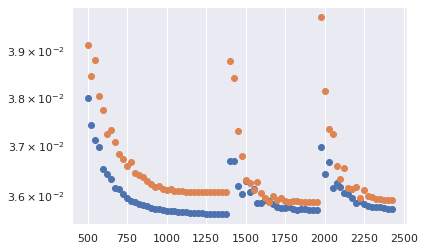

In [42]:
plt.semilogy(df.df[df.keys['loss']].loc[500:], 'o', label='Train')
plt.semilogy(df.df['remaining_loss_test'].loc[500:], 'o', label='Test')


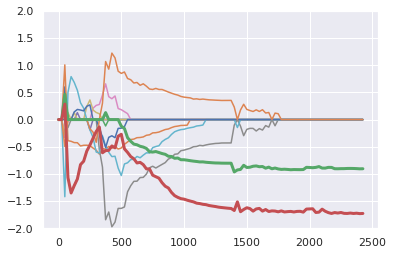

In [43]:
plt.plot(df.df[df.keys['estimator_coeffs']])
plt.plot(df.df[df.keys['estimator_coeffs'][3]], lw=3)
plt.plot(df.df[df.keys['estimator_coeffs'][5]], lw=3)
plt.ylim([-2, 2])
plt.show()

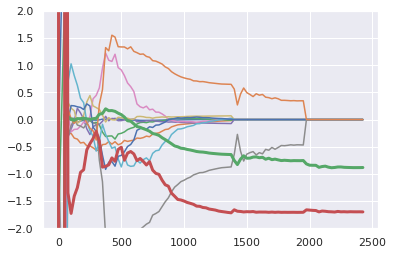

In [44]:
plt.plot(df.df[df.keys['coeffs']])
plt.plot(df.df[df.keys['coeffs'][3]], lw=3)
plt.plot(df.df[df.keys['coeffs'][5]], lw=3)
plt.ylim([-2, 2])
plt.show()

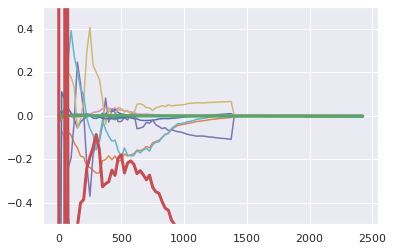

In [45]:
plt.plot(df.df[df.keys['unscaled_coeffs']])
plt.plot(df.df[df.keys['unscaled_coeffs'][3]], lw=3)
plt.plot(df.df[df.keys['unscaled_coeffs'][5]], lw=3)
plt.ylim([-0.5, 0.5])
plt.show()

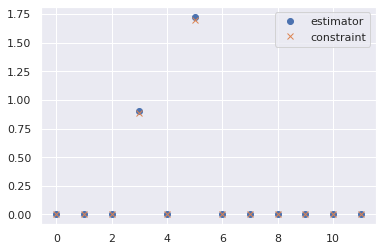

In [46]:
plt.plot(np.arange(12), np.abs(df.df[df.keys['estimator_coeffs']].tail(1).T), 'o', label='estimator')
plt.plot(np.arange(12), np.abs(df.df[df.keys['coeffs']].tail(1).T), 'x', label='constraint')
plt.legend()

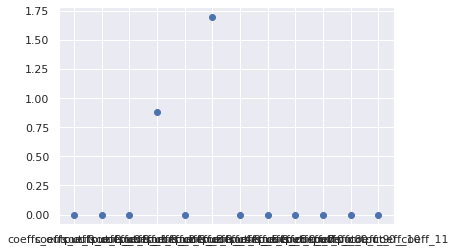

In [47]:
plt.plot(np.abs(df.df[df.keys['coeffs']].tail(1).T), 'o')

In [48]:
predicted = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)
true = y_full.cpu().detach().numpy().reshape(x_grid.shape)

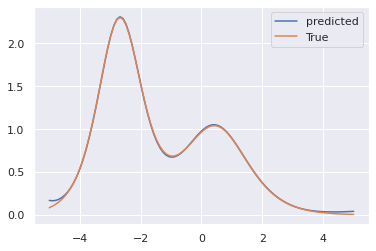

In [49]:
frame = 10
plt.plot(x, predicted[:, frame], label='predicted')
plt.plot(x, true[:, frame], label='True')

plt.legend()

# Scaling

In [6]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

# Running model
sparsity_scheduler = TrainTest(patience=200)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer
_
train_auto_split(model, X, y, optimizer,sparsity_scheduler, split=0.8, log_dir='data/testing_5000_0.1_scaled_test_1/', write_iterations=25, max_iterations=5000, delta=0.01) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1550     31.00%             166s   4.01e-03   4.00e-03   6.08e-06   2.71e+00 [tensor([False, False, False,  True, False,  True, False, False, False, False,
        False, False], device='cuda:0')]
       1750     35.00%             156s   5.66e-03   4.08e-03   1.58e-03   2.57e+00 [tensor([False, False, False,  True, False,  True, False, False, False, False,
        False, False], device='cuda:0')]
       1950     39.00%             146s   5.66e-03   4.08e-03   1.58e-03   2.57e+00 [tensor([False, False, False,  True, False,  True, False, False, False, False,
        False, False], device='cuda:0')]
       2525     50.50%             118s   4.05e-03   4.01e-03   4.34e-05   2.59e+00 Algorithm converged. Stopping training.


In [85]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3, scaled=False) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

# Running model
sparsity_scheduler = TrainTest(patience=200)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer
_
train_auto_split(model, X, y, optimizer,sparsity_scheduler, split=0.8, log_dir='data/testing_5000_0.0_unscaled_test_10/', write_iterations=25, max_iterations=5000, delta=0.01) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1575     31.50%             179s   6.88e-06   1.85e-06   5.03e-06   2.68e+00 Algorithm converged. Stopping training.


In [81]:
# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3, scaled=True) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

# Running model
sparsity_scheduler = TrainTest(patience=200)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer
_
train_auto_split_scaled(model, X, y, optimizer,sparsity_scheduler, split=0.8, log_dir='data/testing_5000_0.0_scaled_test_9/', write_iterations=25, max_iterations=5000, delta=0.01) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
        750     15.00%             219s   3.66e-05   1.94e-05   1.71e-05   3.54e+00 [tensor([False, False, False,  True, False,  True, False,  True, False,  True,
        False, False], device='cuda:0')]
       1000     20.00%             203s   3.26e-05   1.61e-05   1.65e-05   2.89e+00 [tensor([False, False, False,  True, False,  True, False, False, False,  True,
        False, False], device='cuda:0')]
       1200     24.00%             192s   3.25e-05   1.60e-05   1.65e-05   2.86e+00 [tensor([False, False, False,  True, False,  True, False, False, False,  True,
        False, False], device='cuda:0')]
       1400     28.00%             182s   3.25e-05   1.60e-05   1.65e-05   2.86e+00 [tensor([False, False, False,  True, False,  True, False, False, False,  True,
        False, False], device='cuda:0')]
       1600     32.00%             171s   3.25e-05   1.60e-05   1.65e-05   2.86e+00 [tensor([Fal

KeyboardInterrupt: 

In [52]:
model.constraint_coeffs(scaled=True, sparse=True)

[tensor([[ 0.0000],
         [-0.6280],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [-0.1428],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward>)]

In [93]:
df = Results('data/testing_5000_0.0_scaled_test_9/')

Text(0.5, 1.0, 'Total loss')

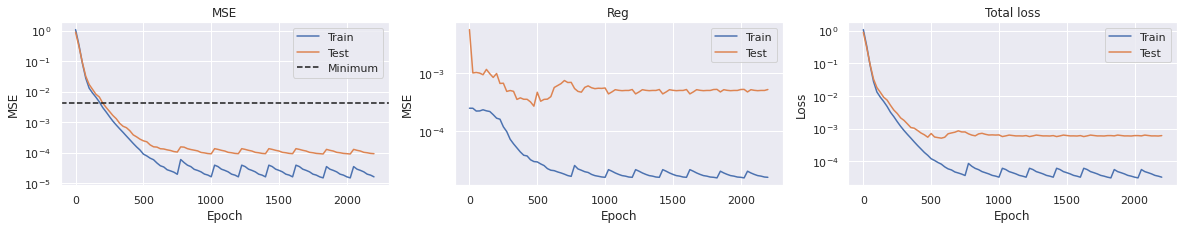

In [94]:
plt.figure(figsize=(20, 3))
plt.subplot(131)

plt.semilogy(df.df[df.keys['mse']], label='Train')
plt.semilogy(df.df['remaining_MSE_test'], label='Test')
plt.axhline(min_MSE, color='k', linestyle='--', label='Minimum')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE')

plt.subplot(132)
plt.semilogy(df.df[df.keys['reg']], label='Train')
plt.semilogy(df.df['remaining_Reg_test'], label='Test')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Reg')


plt.subplot(133)
plt.semilogy(df.df[df.keys['loss']], label='Train')
plt.semilogy(df.df['remaining_loss_test'], label='Test')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total loss')

In [95]:
df.df['remaining_loss_test'].idxmin()

575

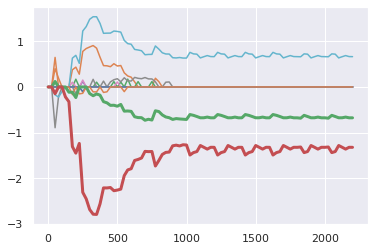

In [96]:
plt.plot(df.df[df.keys['estimator_coeffs']])
plt.plot(df.df[df.keys['estimator_coeffs'][3]], lw=3)
plt.plot(df.df[df.keys['estimator_coeffs'][5]], lw=3)
plt.show()

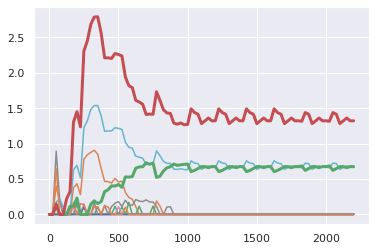

In [97]:
plt.plot(np.abs(df.df[df.keys['estimator_coeffs']]))
plt.plot(np.abs(df.df[df.keys['estimator_coeffs'][3]]), lw=3)
plt.plot(np.abs(df.df[df.keys['estimator_coeffs'][5]]), lw=3)
plt.show()

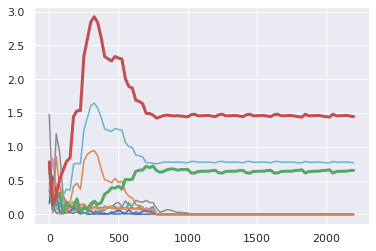

In [99]:
plt.plot(np.abs(df.df[df.keys['coeffs']]))
plt.plot(np.abs(df.df[df.keys['coeffs'][3]]), lw=3)
plt.plot(np.abs(df.df[df.keys['coeffs'][5]]), lw=3)
plt.show()

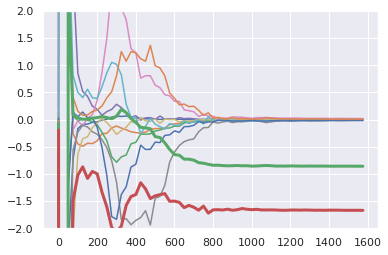

In [92]:
plt.plot(df.df[df.keys['coeffs']])
plt.plot(df.df[df.keys['coeffs'][3]], lw=3)
plt.plot(df.df[df.keys['coeffs'][5]], lw=3)
plt.ylim([-2, 2])
plt.show()